## Data Manipulation

In [3]:
# import modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'pandas'

## HTS Data

In [ ]:
# load datasets
hts_df = pd.read_csv('./clean_data/clean_hts.csv')
pmtct_df = pd.read_csv('./clean_data/merged_pmtct.csv')

# hts_merged = pd.concat([hts_migori, hts_kakamega], ignore_index=True)
hts_df.head()

In [ ]:
# Grouping the hts data based on facilityuid and period
hts_df = hts_df.groupby(['facilityuid', 'period']).agg({'dhis2_value': 'sum', 'datim_value': 'sum'})

hts_df

### Data Visualization

In [ ]:
numerical = sns.lineplot(x='period', y='dhis2_value', data=hts_df)

In [ ]:
numerical2 = sns.lineplot(x='period', y='datim_value', data=hts_df)

### We can observe that the number of DHIS and DATIM value reports decrease with each subsequent quarter in HTS data

In [ ]:
# reset index
hts_df = hts_df.reset_index()
hts_df

In [ ]:
# rename columns to total after grouping by
hts_df = hts_df.rename(columns={'dhis2_value': 'total_dhis2_value_hts', 'datim_value': 'total_datim_value_hts'})
hts_df

In [ ]:
# get difference of total datim and dhis
hts_df['difference_hts'] = hts_df['total_dhis2_value_hts'] - hts_df['total_datim_value_hts']
hts_df

In [ ]:
# compute percentage difference
hts_df['percentage_difference_hts'] = abs(hts_df['difference_hts'] / hts_df['total_datim_value_hts'] * 100)
hts_df

## PMTCT Data

In [ ]:
# hts_merged = pd.concat([hts_migori, hts_kakamega], ignore_index=True)
pmtct_df.head()

In [ ]:
pmtct_df = pmtct_df.groupby(['facilityuid', 'period']).agg({'dhis2_value': 'sum', 'datim_value': 'sum'})

pmtct_df

## PMTCT Visualization

In [ ]:
numerical = sns.lineplot(x='period', y='dhis2_value', data=pmtct_df)

In [ ]:
numerical2 = sns.lineplot(x='period', y='datim_value', data=hts_df)

In [ ]:
numerical2 = sns.lineplot(x='period', y='datim_value', data=hts_df)

### We can observe that the number of DHIS values decreases from the first quarter till 2019Q4 then increases while the DATIM value reports decrease with each subsequent quarter in PMTCT data

In [ ]:
# reset data
pmtct_df = pmtct_df.reset_index()
pmtct_df

In [ ]:
# rename column names
pmtct_df = pmtct_df.rename(columns={'dhis2_value': 'total_dhis2_value_pmtct', 'datim_value': 'total_datim_value_pmtct'})
pmtct_df

In [ ]:
# compute difference
pmtct_df['difference_pmtct'] = pmtct_df['total_dhis2_value_pmtct'] - pmtct_df['total_datim_value_pmtct']
pmtct_df

In [ ]:
# compute percentage difference
pmtct_df['percentage_difference_pmtct'] = abs(pmtct_df['difference_pmtct'] / pmtct_df['total_datim_value_pmtct'] * 100)
pmtct_df

# Merge PMTCT and HTS

In [ ]:
merged_df = pd.merge(hts_df, pmtct_df, on=["facilityuid","period"])
merged_df

In [ ]:
# calculate median
cutoff = merged_df["percentage_difference_hts"].median()
print(cutoff)
rejected_at_first_sight = merged_df[merged_df['percentage_difference_hts'] > cutoff]
rejected_at_first_sight

Here the median is chosen as a point of judgement to decide and to flag out the facilities which were not accepted at first sight. This could vary according to the user's point of accuracy and can be adjusted accordingly. For this dataset an assunption of median is made because it is smallerr as compared to mean.

In [ ]:
# get the rejected at first_sight
len(merged_df) - len(rejected_at_first_sight)

In [ ]:
data = {"accepted": (len(merged_df) - len(z)),
        "rejected_at_first": len(z)}

x_data = list(data.keys())
y_data = list(data.values())


bar = plt.bar(x_data, y_data, color ='maroon',
        width = 0.4)
bar[0].set_color('g')
bar[1].set_color('r')
plt.xlabel("acceptance")
plt.ylabel("Total count")
plt.title("Relational plot between accepted and rejected")
plt.show()

From the bar plot above we know that there's a problem with the presented data. If values in the percentage_difference column are above cutoff which is defined by the median value, an assumption is made that the facilities did not submit their PMTCT results. We add the PMTCT results to the respective columns.

In [ ]:
# create a column to define whether accepted or not
merged_df['accept'] = merged_df['percentage_difference_hts'].apply(lambda x: 'yes' if x < cutoff else 'no')
merged_df

In [ ]:
len(merged_df[merged_df['accept'] == 'no'])


### Flag out the facilities which were rejected at first sight

In [ ]:
rejected = merged_df[merged_df['accept'] == 'no']
rejected

### Giving second chance to the rejected data

In [ ]:
# compute a new difference
if (rejected['difference_hts'] < 0).any():
    rejected['new_difference'] = rejected['total_dhis2_value_pmtct'] + rejected['difference_hts']
else:
    rejected['new_difference'] = rejected['total_datim_value_pmtct'] + rejected['difference_hts']

rejected

In [ ]:
rejected['new_percentage_difference']= abs(rejected['new_difference']/ rejected['total_datim_value_hts']* 100)
rejected

In [ ]:
# compute a new percentage difference
new_cutoff = rejected["new_percentage_difference"].mean()
print(new_cutoff)

# get the new rejected
b = rejected[rejected['new_percentage_difference'] > new_cutoff]
b

In [ ]:
# define a new acceptance column with if-else conditions
rejected['new_accept'] = rejected['new_percentage_difference'].apply(lambda x: 'yes' if x < new_cutoff else 'no')
rejected

In [ ]:
rejected['accept'] = rejected['new_accept']
rejected

In [ ]:
merged_df = merged_df[merged_df['accept'] != 'no'].copy()
merged_df

In [ ]:
rejected.drop(['new_difference','new_percentage_difference', 'new_accept'], axis=1, inplace=True)
rejected

In [ ]:
final_merge = pd.concat([merged_df, rejected], axis=0)
final_merge

### Visualize the second acceptance

In [ ]:
total_rejected = len(final_merge[final_merge['accept'] == 'no'])

total_accepted = len(final_merge[final_merge['accept'] == 'yes'])

In [ ]:
new_data = {"total_accepted": total_accepted,
        "total_rejected": total_rejected}

x_data = list(new_data.keys())
y_data = list(new_data.values())


bar2 = plt.bar(x_data, y_data, color ='maroon',
        width = 0.4)
bar2[0].set_color('g')
bar2[1].set_color('r')
plt.xlabel("acceptance")
plt.ylabel("Total count")
plt.title("Relational plot between accepted and rejected")
plt.show()

In [ ]:
final_merge.info()

# Creating the binary classification model

In [ ]:
from sklearn import linear_model, model_selection, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [ ]:
final_merge['period'].unique()

In [2]:
#converting categorical data to numerical data
label_encoder = preprocessing.LabelEncoder()

# Three columns have categorical text info, and we convert them to numbers
final_merge['accept'] = label_encoder.fit_transform(final_merge['accept'])
final_merge['period'] = label_encoder.fit_transform(final_merge['period'])
final_merge

NameError: name 'preprocessing' is not defined

In [ ]:
final_merge['period'].unique()

In [ ]:
final_merge.reset_index(drop=True, inplace=True)
final_merge

In [ ]:
#converting facilityuid to index values
final_merge.rename(columns={'index': 'facilityuid'}, inplace=True)
final_merge

In [ ]:
#selecting dependent and independent variables
y= final_merge['accept']

#Remove columns we are not interested in
final_merge.drop(['facilityuid', 'difference_pmtct','difference_hts', 'percentage_difference_pmtct', 'accept'], axis=1, inplace=True)

#Saving the rest of the data as input data
X = final_merge

In [ ]:
len(X)

In [ ]:
X.columns

In [ ]:
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [ ]:
#Create a Decision Tree Classifier
tree_model= DecisionTreeClassifier(random_state=0, max_depth=5)

In [ ]:
#Splitting dataset

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=99)

In [ ]:
len(X_train)
X_test

In [ ]:
# set index
X_test

In [ ]:
len(X_test)

In [ ]:
#Fitting the model into training data
tree_model.fit(X_train, y_train)

In [ ]:
#Create a pickle file to bundle the model using pickle library
import pickle

picklefile = 'model.pkl'
#open file in binary write mode
with open(picklefile, 'wb') as file:
    pickle.dump(tree_model, file)
#model.pkl -> serialized trained decision tree classifier model

## Visualization

In [ ]:
text_representation = tree.export_text(tree_model)
print(text_representation)

In [ ]:
# save file
with open("decistion_tree.log", "w") as fout:
    fout.write(text_representation)

## Prediction

In [ ]:
#Do predictions on test data
y_pred= tree_model.predict(X_test)
print(y_pred)

In [ ]:
import numpy as np
total_pred_accepted = np.count_nonzero(y_pred==1)
total_pred_rejected = np.count_nonzero(y_pred==0)
total_pred_accepted

final_data = {"final_accepted": total_pred_accepted,
        "final_rejected": total_pred_rejected}

x_data = list(final_data.keys())
y_data = list(final_data.values())


bar = plt.bar(x_data, y_data, color ='maroon',
        width = 0.4)
bar[0].set_color('g')
bar[1].set_color('r')
plt.xlabel("acceptance")
plt.ylabel("Total count")
plt.title("Relational plot between accepted and rejected")
plt.show()

In [ ]:
len(y_pred)

In [ ]:
#Calculate accuracy
tree_model.score(X_test, y_test) * 100

In [ ]:
#finding F1 score
from sklearn.metrics import f1_score

f1_score(y_test, y_pred)

In [ ]:
# save file
with open("decistion_tree.log", "w") as fout:
    fout.write(text_representation)

## Prediction

In [ ]:
#Do predictions on test data
y_pred= tree_model.predict(X_test)
print(y_pred)

[1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1]


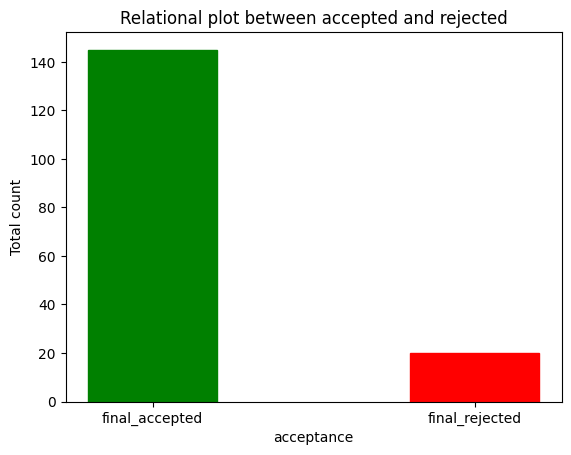

In [ ]:
import numpy as np
total_pred_accepted = np.count_nonzero(y_pred==1)
total_pred_rejected = np.count_nonzero(y_pred==0)
total_pred_accepted

final_data = {"final_accepted": total_pred_accepted,
        "final_rejected": total_pred_rejected}

x_data = list(final_data.keys())
y_data = list(final_data.values())


bar = plt.bar(x_data, y_data, color ='maroon',
        width = 0.4)
bar[0].set_color('g')
bar[1].set_color('r')
plt.xlabel("acceptance")
plt.ylabel("Total count")
plt.title("Relational plot between accepted and rejected")
plt.show()

In [ ]:
len(y_pred)

165

In [ ]:
#Calculate accuracy
tree_model.score(X_test, y_test) * 100

95.15151515151516

In [ ]:
#finding F1 score
from sklearn.metrics import f1_score

f1_score(y_test, y_pred)

0.9726027397260274